In [1]:
# Reference: https://jupyterbook.org/interactive/hiding.html
# Use {hide, remove}-{input, output, cell} tags to hiding content

import sys
import os
sys.path.append(os.path.abspath('../../..'))
from textbook_utils import *

import plotly.figure_factory as ff

In [2]:
trees = pd.read_csv('data/black_spruce.csv')

In [3]:
trees['status_0_1'] = 0 + (trees['status'] == 'fallen')

In [4]:
from sklearn.linear_model import LogisticRegression

trees['log_diam'] = np.log(trees['diameter']) 
X = trees[['log_diam']].to_numpy()
y = trees['status_0_1'].to_numpy()

lr_model = LogisticRegression(solver="lbfgs")
lr_model.fit(X, y)

LogisticRegression()

# Interpreting the Probabilities for Classification

We started this chapter by stating a binary classification problem where we want to model a nominal response variable. At this point, we have used logistic regression to model proportions or probabilities, and we're now ready to return to the original problem.
We use the predicted probabilities to classify records. For our example, this means that for a tree of a particular diameter, we use the fitted coefficients from the logistic regression to estimate the chance it is fallen. If the chance is high, we classify a tree as fallen and we classify it as standing if the predicted chance is low. But, we need to choose a threshold for making this *decision rule*.

The `sklearn` logistic regression model's `predict` function implements the basic decision rule: predict 1 if $\sigma(\hat{\theta}_0 + \hat{\theta}_1 x)> 0.5$ otherwise predict 0. We confirm this with:

In [5]:
np.all(lr_model.predict(X) == 
       np.where(lr_model.predict_proba(X)[:,1] > 0.5, 1.0, 0.0))

True

In this section, we consider a more general decision rule:

Predict 1 if $\sigma(\hat{\theta}_0 + \hat{\theta}_1 x)> \tau$ otherwise predict 0, for some choice of $\tau$.  

Choosing an appropriate value for $\tau$ depends on our goals. Suppose we wanted to maximize accuracy.  The *accuracy* of a classifier is defined as the fraction of correct predictions.  We can compute the accuracy for different thresholds:

In [6]:
def threshold_predict(model, X, threshold): 
    return np.where(lr_model.predict_proba(X)[:,1] > threshold, 1.0, 0.0)

In [7]:
def accuracy(threshold, X, y):
    return np.mean(threshold_predict(lr_model, X, threshold) == y)

In [8]:
thresholds = np.linspace(0, 1, 200)
accs = [accuracy(t, X, y) for t in thresholds]

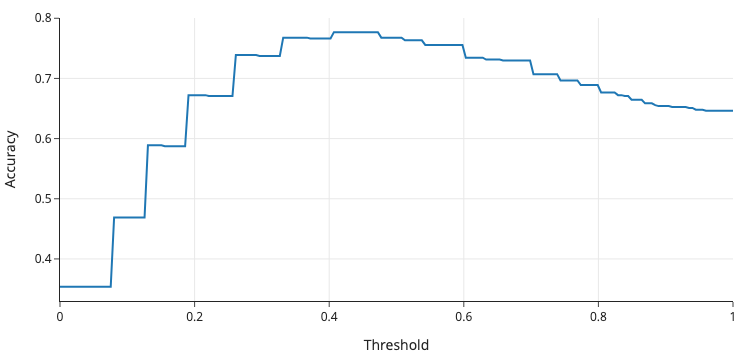

In [9]:
fig = px.line(x=thresholds, y=accs, 
              width=450, height=250)
fig.update_xaxes(title="Threshold")
fig.update_yaxes(title="Accuracy")

In practice we should use cross validation to select the threshold (see {numref}`Chapter %s <ch:risk>`).

Notice that the threshold with the highest accuracy is not necessarily at 0.5.  This can occur for many reasons but a common reason is *class imbalance*, when one category is more frequent than another. When this happens, then we do better to classify a record as belonging to the more frequently observed category. We have seen this phenomenon when fitting the constant model. This explains why accuracy alone is often not how we want to judge a model. Instead, we want to differentiate between the types of correct and incorrect classifications.    

## The Confusion Matrix

A convenient way to visualize errors in a classification model is to look at the confusion matrix.  The confusion matrix compares what the model predicts with the actual outcomes in each class. There are two types of error in this situation:

1. *False-Positives*: When the actual class is 0 (false) but the algorithm predicts 1 (true).
1. *False-Negatives*: When the actual class is 1 (true) but the algorithm predicts 0 (false).

Ideally, we would like to minimize the sources of both kinds of errors, but we often need to manage the balance between these types of error.  

Scikit-learn has a function to compute the confusion matrix:

In [10]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y, lr_model.predict(X))
mat

array([[377,  49],
       [104, 129]])

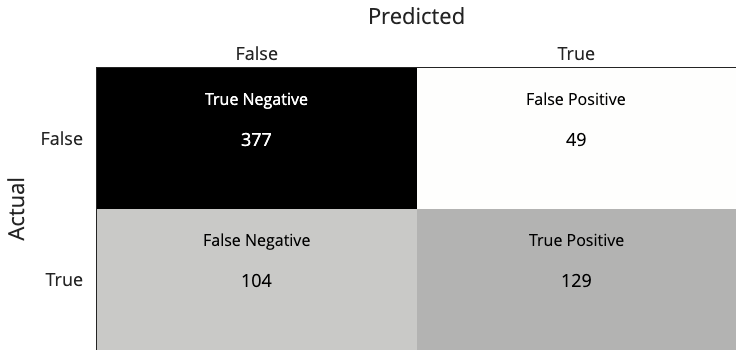

In [11]:
fig = ff.create_annotated_heatmap(z=mat,
                                  x=["False", "True"], y=["False", "True"], 
                                  showscale=False, 
                                 colorscale=px.colors.sequential.gray_r)
fig.update_layout(font=dict(size=18), width=350, height=300)
# Add Labels
fig.add_annotation(x=0,y=0, text="True Negative", 
                   yshift=40, showarrow=False, font=dict(color="white",size=16))
fig.add_annotation(x=1,y=0, text="False Positive", 
                   yshift=40, showarrow=False, font=dict(color="black",size=16))
fig.add_annotation(x=0,y=1, text="False Negative", 
                   yshift=40, showarrow=False, font=dict(color="black",size=16))
fig.add_annotation(x=1,y=1, text="True Positive", 
                   yshift=40, showarrow=False, font=dict(color="black",size=16))

fig.update_xaxes(title="Predicted")
fig.update_yaxes(title="Actual", autorange="reversed")

It can be more informative if we compare the rates, rather than counts. Next, we describe two different rates and when we might prefer to prioritize one of the other.   

## Precision vs Recall

In some settings, there might be a much higher cost to missing positive cases.  For example, if we are building a tumor classifier we want to make sure that we don't miss any malignant tumors. So, we prefer to classify benign tumors as malignant because further study can be conducted by a pathologist to verify a malignant classification. In this case we want to have a true positive rate, also called *sensitivity* and *recall*.

$$
\text{Recall} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}} = \frac{\text{True Positives}}{\text{Actually True}}
$$

Higher recall runs the risk of predicting true on false examples.

On the other hand, in classifying email as spam (positive) or ham (negative), we might be annoyed if an important email gets thrown into our spam folder. In this setting, we want to adjust the *precision* of a model, the accuracy of the model for positive predictions:

$$
\text{Precision} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}} = \frac{\text{True Positives}}{\text{Predicted True}}
$$

Higher precision models are often more likely to predict that true things are negative (higher false negative rate).

A common analysis is to compare the precision and recall at different thresholds.  There is a scikit-learn function to compute this tradeoff. It computes the precision and recall at different thresholds.

In [12]:
from sklearn import metrics
precision, recall, threshold = metrics.precision_recall_curve(y, 
                                                lr_model.predict_proba(X)[:, 1])

The precision and recall are computed for all possible probability thresholds:

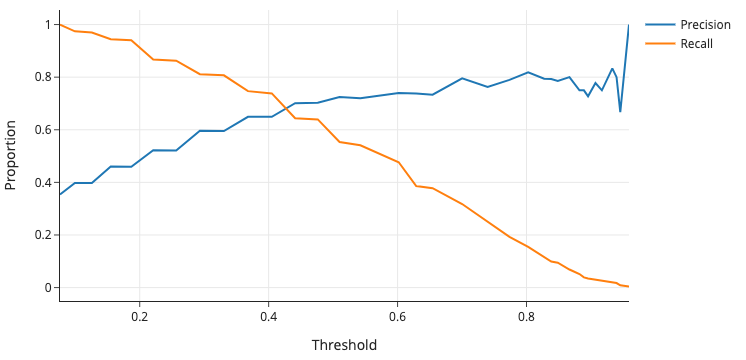

In [13]:
fig = go.Figure()
fig.add_trace(go.Scatter(name="Precision", x=threshold, y=precision[:-1]))
fig.add_trace(go.Scatter(name="Recall", x=threshold, y=recall[:-1]))
fig.update_xaxes(title="Threshold")
fig.update_yaxes(title="Proportion")
fig

If we wanted to ensure that at least 75% of the fallen trees are classified as fallen,
we can find the threshold where this would occur:

In [14]:
fall75_ind = np.argmin(recall >= 0.75)-1
fall75_thresh = threshold[fall75_ind]
fall75_precision = precision[fall75_ind]
fall75_recall = recall[fall75_ind]

print(f"Threshold: {fall75_thresh:0.2f}")
print(f"Precision: {fall75_precision:0.2f}")
print(f"Recall: {fall75_recall:0.2f}")

Threshold: 0.33
Precision: 0.59
Recall: 0.81


We would then find that roughly 41% (1-precision) of the trees we classify as fallen would actually be standing. With this threshold we find the fraction of trees below this threshold to be:

In [15]:
print("Proportion of samples below threshold:", 
      f"{np.mean(lr_model.predict_proba(X)[:,1] < fall75_thresh):0.2f}")

Proportion of samples below threshold: 0.52


That means that we would classify 52% of the samples as standing (negative). *Specificity* (also called *true negative rate*) measures the proportion of data belonging to the negative class that the classifier labels as negative.

$$
\text{Specifity} = \frac{\text{True Negatives}}{\text{True Negatives} + \text{False Positives}} = \frac{\text{True Negatives}}{\text{Predicted False}}
$$

The specificity for our threshold is: 

In [17]:
act_neg = y ==0
true_neg = (lr_model.predict_proba(X)[:,1] < fall75_thresh) & act_neg

print(f"Specificity: {np.sum(true_neg) / np.sum(act_neg):0.2f}")

Specificity: 0.70


In other words, 70% of the trees classified as standing are actually standing.

For a simple 2 by 2 table of counts, there are many different ways to look at it. Ideally, we want all of these rates to be high. This happens when the data fall entirely along the diagonal for the table and are only either true negatives or true positives. Unfortunately, that doesn't usually happen. In our example, trees of the same diameter include a mix of fallen and standing so we can't perfectly classify trees based on their diameter. In practice, when we choose a threshold, we need to consider the context and way these notions of precision and recall.  